# Self-Driving Car Engineer Nanodegree

* **Project: Advanced Lane Lines** 

* **Author:   Matt Kontz**

* **Start date:  January 29, 2019**



# Import Packages
Import package to be use throughout project notebook

In [1]:
#importing some useful packages
import os

import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2

%matplotlib inline

# Camera Calibration

## Create list of Calibration Image Files

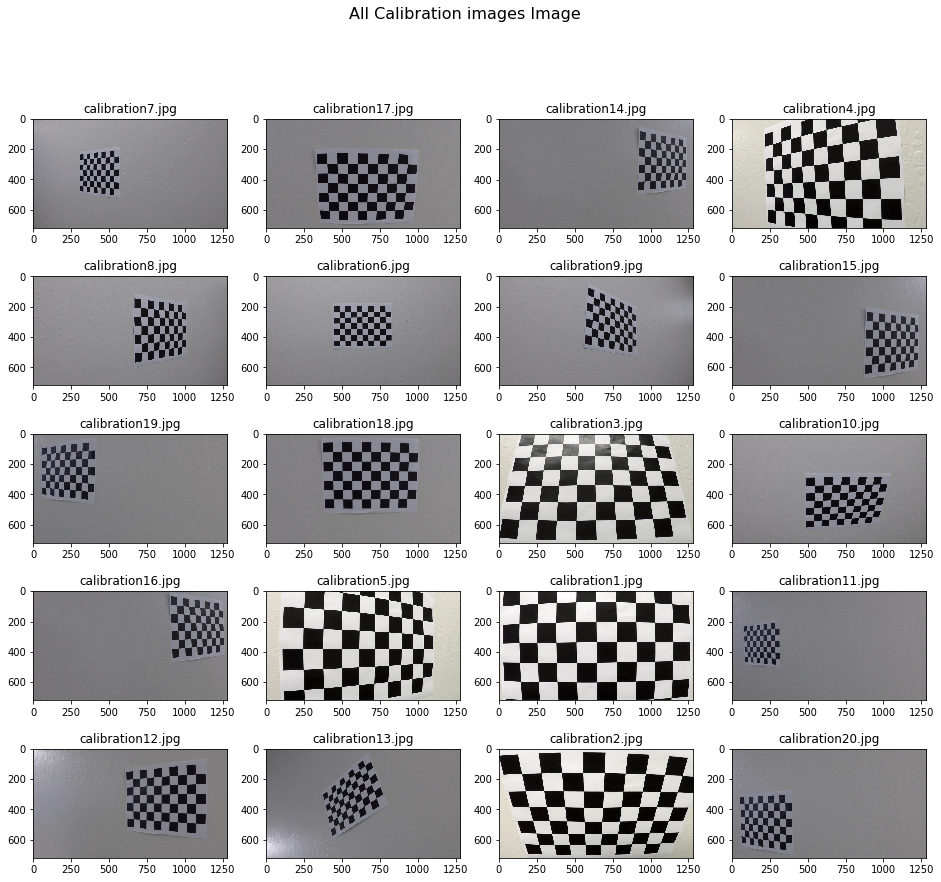

In [2]:
# Find calibration image names 
calImageNames = os.listdir("camera_cal/")

nRow = 5
nCol = 4

fig, ax = plt.subplots(nRow, nCol, figsize=(16, 14))
fig.suptitle("All Calibration images Image", fontsize=16)

for r in range(nRow):    
    for c in range(nCol):
        k = r * nCol + c
        if (k < len(calImageNames)):
            image = mpimg.imread("./camera_cal/" + calImageNames[k])
            ax[r,c].imshow(image)
            ax[r,c].set_title(calImageNames[k])

fig.savefig('output_images/cal_images.png')


## Create List of Image and Object Points for Camera Calibration

* Create empty lists for object and image points
* Create object points once as this will be the same for all images
* Iterate through calibration images
    * load image
    * convert to grey scale
    * find corners (i.e. image points) using findChessboardCorners
    * if success append image and object points to list
    
Notice that several of the images fail to produce image points as shown in the plot below.  This appears to because some of the corners on the images that failed are not included in the image.

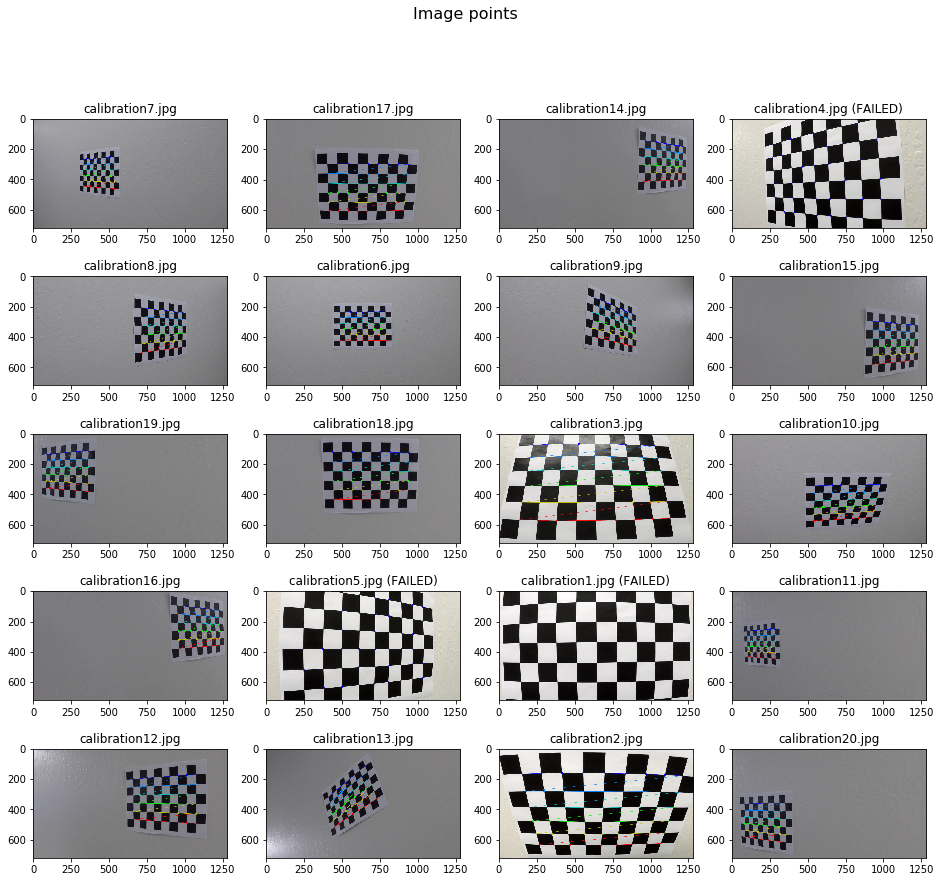

In [3]:
imgpoints = []
objpoints = []

objpnt = np.zeros((6*9,3), np.float32)
objpnt[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Create figure to plot image points on calibration images
nRow = 5
nCol = 4
fig, ax = plt.subplots(nRow, nCol, figsize=(16, 14))
fig.suptitle("Image points", fontsize=16)

for k in range(len(calImageNames)):
    fname = calImageNames[k]
    
    # load a calibration image
    raw_img = mpimg.imread("./camera_cal/" + fname)
    raw_plot = plt.imshow(raw_img)

    # convert to gray scale image
    gray = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret:
        # if points are found then append to list of image and object points
        imgpoints.append(corners)
        objpoints.append(objpnt)
        
    c = int(k % nCol)
    r = int((k - c) / nCol)
    corner_lines_img = cv2.drawChessboardCorners(raw_img, (9, 6), corners, ret)
    ax[r,c].imshow(corner_lines_img)
    if ret:
        ax[r,c].set_title(calImageNames[k])
    else:
        ax[r,c].set_title(calImageNames[k] + ' (FAILED)')

fig.savefig('output_images/cal_image_points.png')
    
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# Distortion Correction

The camera calibration calculated five parameters
 
* ret - (return value) boolean that indicates success
* mtx - (camera matrix) 
    * focal length = ( f<sub>x</sub> f<sub>y</sub> )
    * optical centers = ( c<sub>x</sub> c<sub>y</sub> )
\begin{equation*}
    mtx = \left( 
        \begin{matrix}
        f_x & 0 & c _x\\
        0 & f_y & c_y \\
        0 & 0 & 1 \\
    \end{matrix} \right)
\end{equation*}

* dist - (distortion coefficients)
\begin{equation*} 
    dist = \left[ k_1 k_2 p_1 p_2 k_3 \right] 
\end{equation*}
* rvecs - (rotation vectors) 
* tvecs - (translation vectors)

The two calibration parameters required for removing distortion are the camera martix (mtx) and distortion coefficients (dist) to produce an undistorted image.  These two parameters along with the original image are fed into cv2.undistort().  These to parameter and cv2.undistort() will be used throughout this project.  See sample below.


## Undistort function
This function takes the distorted image and returns the undistorted image.

In [4]:
def Undistort(image):
    # undistort image
    return cv2.undistort(image, mtx, dist, None, mtx)

## Verify Calibration on Sample Image
The test image is actually one of the image that failed to be added to the calibration set because not all the corners are include in the image.  There are only (9 x 5) corners instead of (9 x 6) corners.  Since this test image is straight on and zoomed in it clearly shows distortion correction because all the boxes and lines are straight in the undistorted image.

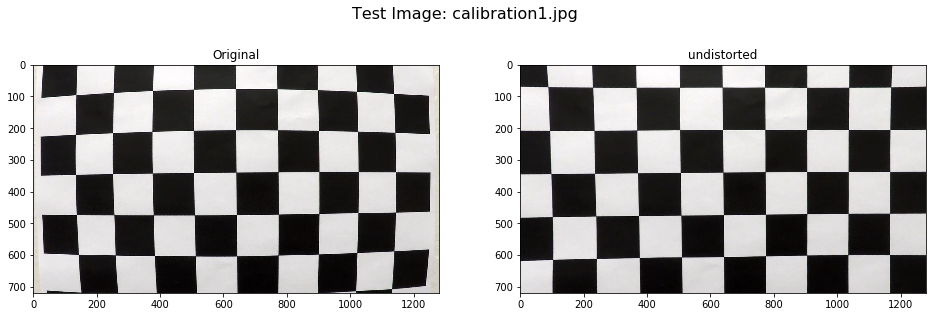

In [5]:
# load and plot Sample image
fname = 'calibration1.jpg'
sample_img = mpimg.imread("./camera_cal/" + fname)

dst = Undistort(sample_img)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Test Image: " + fname, fontsize=16)

ax[0].imshow(sample_img)
ax[0].set_title('Original')
    
ax[1].imshow(dst)
ax[1].set_title('undistorted')

fig.savefig('output_images/undistorted_chessboard.png')


# Color/Gradient Threshold

In [6]:

def ColorThreshold(dst_img, s_thresh = (170, 255)):
    # convert to HLS (hue, lightness, and saturation) color space
    HLS_img = cv2.cvtColor(dst_img, cv2.COLOR_RGB2HLS)
    
    # select saturation channel
    S = HLS_img[:,:,2]
    
    binary_output = np.zeros_like(S)
    binary_output[(s_thresh[0] < S) & (S <= s_thresh[1])] = 1

    return binary_output

def GrayGradTheshold(dst_img, sx_thresh = (20, 200)):
    #convert to gray scale image
    gray = cv2.cvtColor(dst_img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    binary_output = np.zeros_like(scaled_sobelx)
    binary_output[(sx_thresh[0] < scaled_sobelx) & (scaled_sobelx <= sx_thresh[1])] = 1

    return binary_output

def ColarGradientThreshold(dst_img, s_thresh = (170, 255), sx_thresh = (20, 255)):
    color_th_img = ColorThreshold(dst_img, s_thresh = (170, 255))   
    grad_th_img = GrayGradTheshold(dst_img, sx_thresh = (20, 200))
    
    return np.bitwise_or(color_th_img, grad_th_img)

## Verify and Visualize

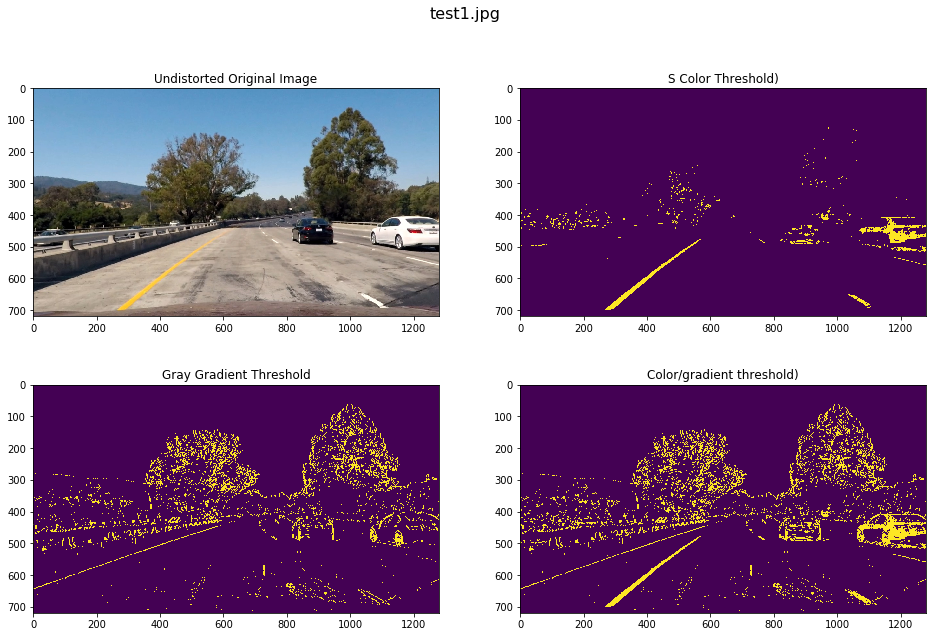

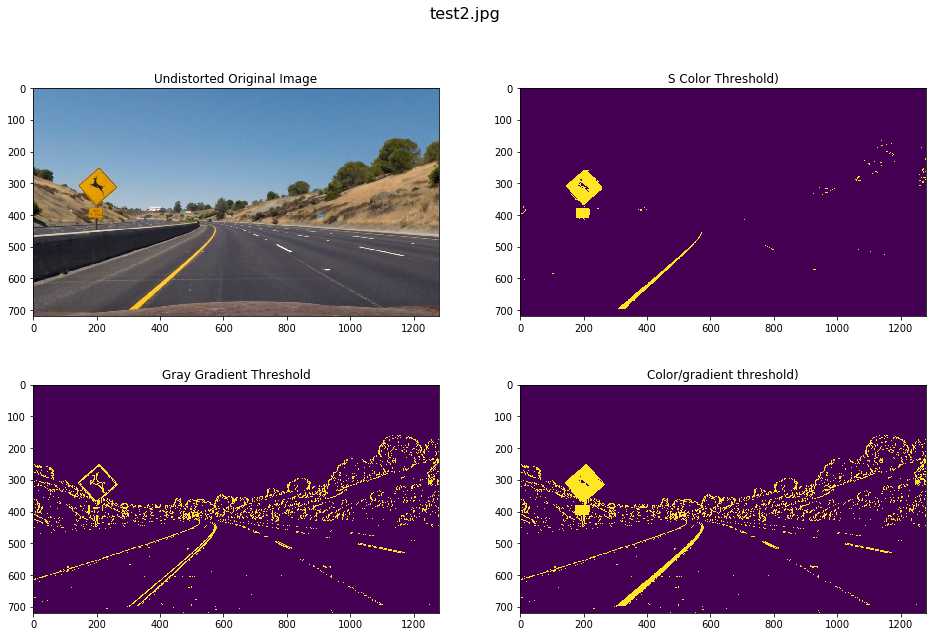

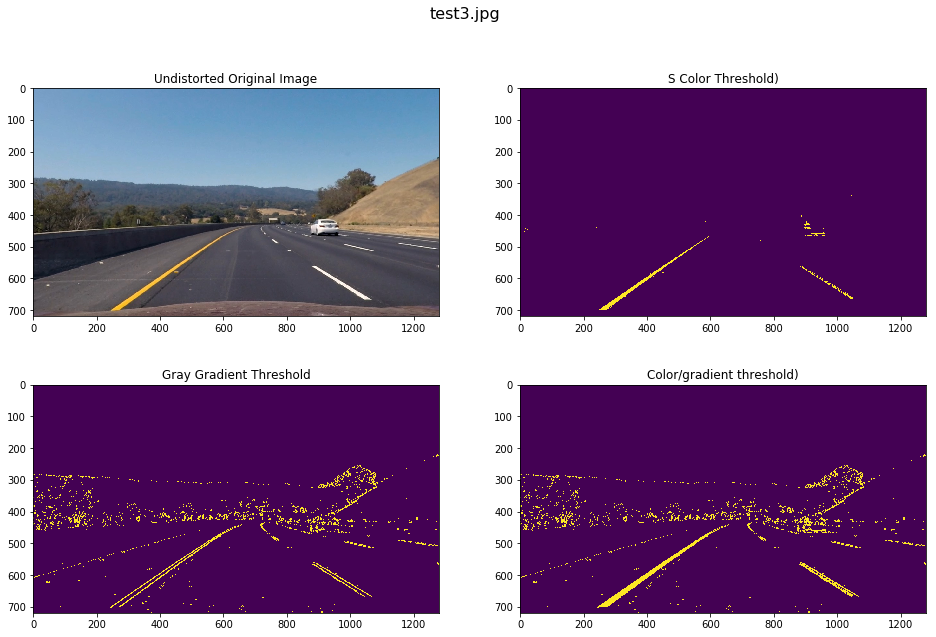

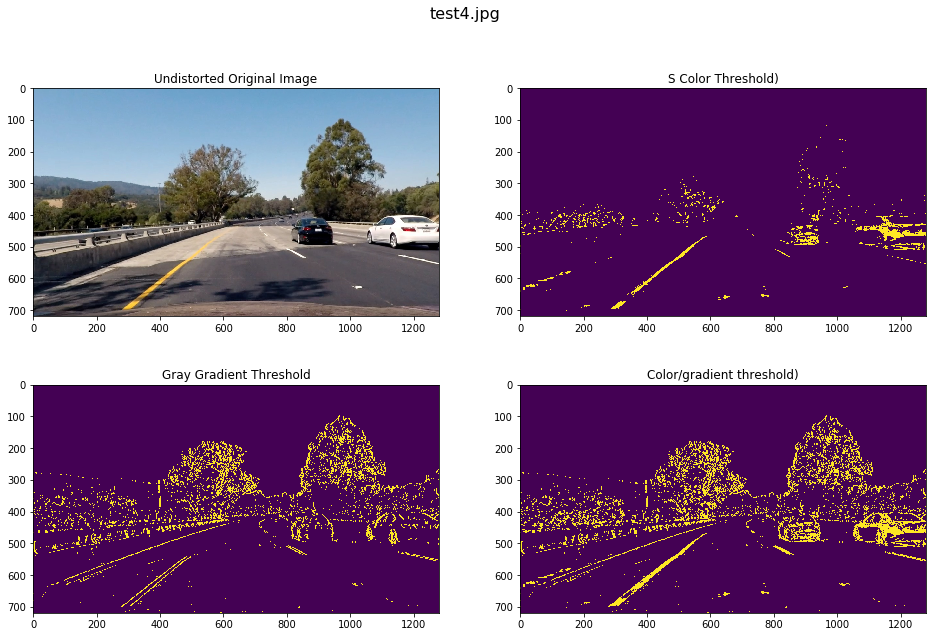

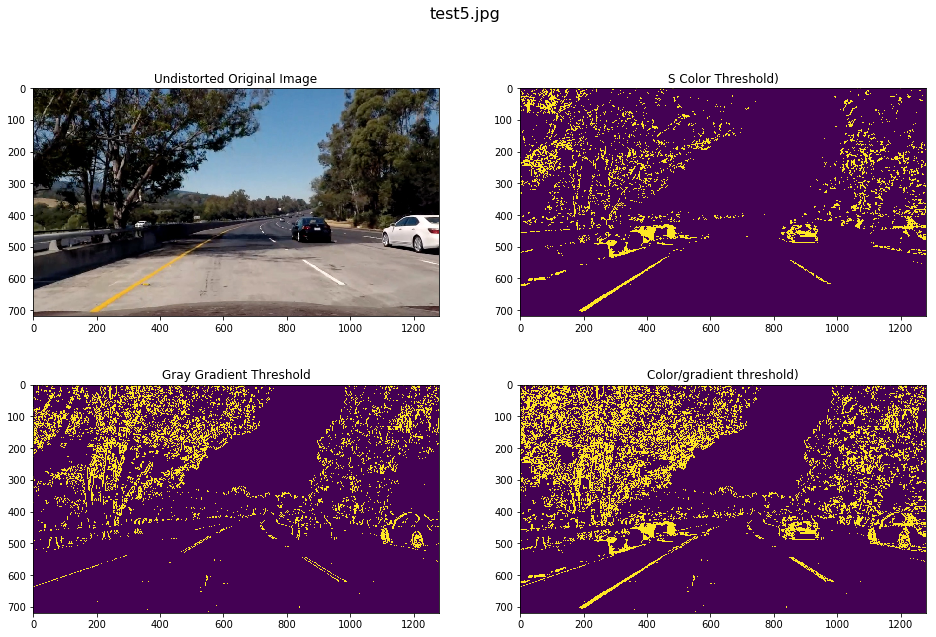

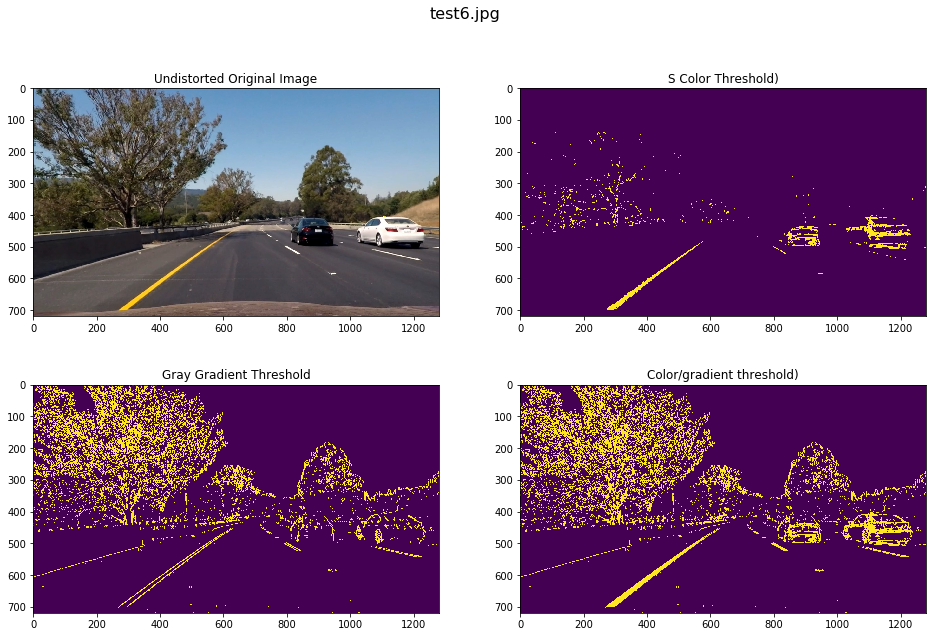

In [7]:

for k in range(1,7):
    # load test image
    fname = 'test' + str(k) + '.jpg'
    raw_img = mpimg.imread('test_images/' + fname)
    
    dst = cv2.undistort(raw_img, mtx, dist, None, mtx)
    
    color_th_img = ColorThreshold(dst, s_thresh = (170, 255))
    
    grad_th_img = GrayGradTheshold(dst, sx_thresh = (20, 200))

    color_grad_im = ColarGradientThreshold(dst, s_thresh = (170, 255), sx_thresh = (20, 200)) 
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(fname, fontsize=16)
    
    ax[0, 0].imshow(dst)
    ax[0, 0].set_title('Undistorted Original Image')

    ax[0, 1].imshow(color_th_img)
    ax[0, 1].set_title('S Color Threshold)')
    
    ax[1, 0].imshow(grad_th_img)
    ax[1, 0].set_title('Gray Gradient Threshold')

    ax[1, 1].imshow(color_grad_im)
    ax[1, 1].set_title('Color/gradient threshold)')
    
    fig.savefig('output_images/' + fname[:-4] + '_out.png')

# Perspective Transform

## Perspective Transform and Visualization Functions

In [8]:
def drawPolygonLines(img, pnts, color = (50, 200, 50), thickness = 10):
    # Create black image the same size as img to draw the lines on
    poly_line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.polylines(poly_line_img, [pnts], False, color, thickness)
    
    return poly_line_img
    
def drawPolygonFill(img, pnts, color = (50, 200, 50)):
    # Create black image the same size as img to draw the polygon shape
    poly_fill_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.fillPoly(poly_fill_img, np.int_([pnts]), color)
    
    return poly_fill_img

#   from Project 1
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def changePerspective(image_in, M):
    # use cv2.warpPerspective() to warp your image to a top-down view
    return cv2.warpPerspective(image_in, M, image_in.shape[1::-1], flags=cv2.INTER_LINEAR)


## Verify and Visualize Perspective Transforms

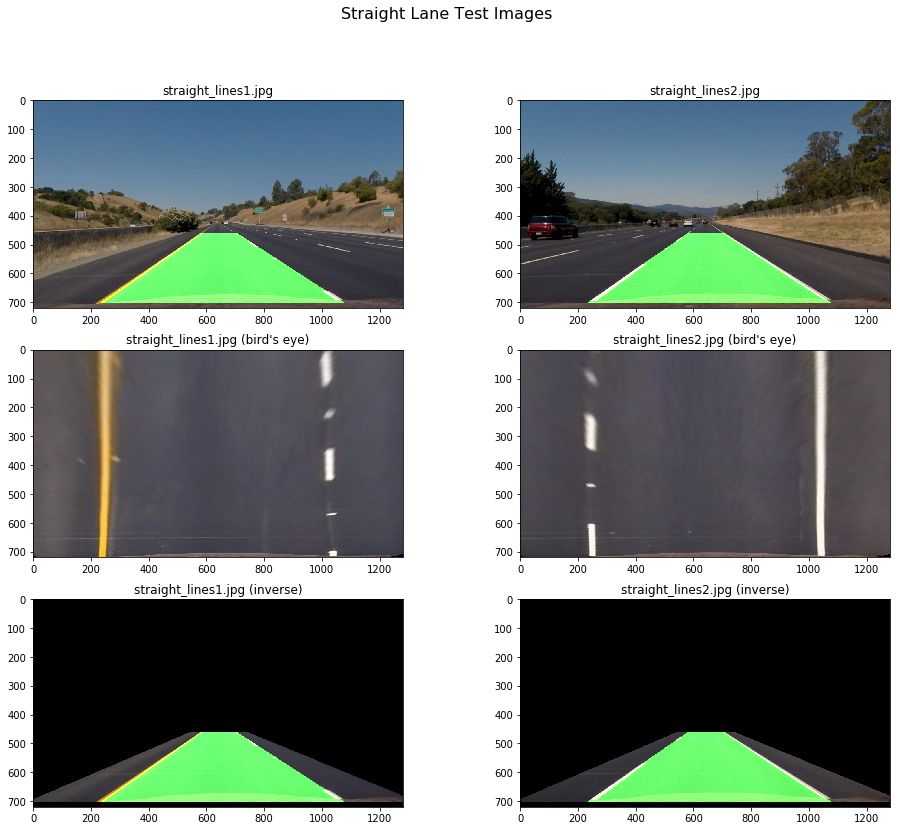

In [28]:
# points in pixels defining polygon to draw on images
s_pnts = np.array([[235, 700], [580, 460], [705, 460], [1075, 700]])
src_pnts = np.float32(s_pnts)
dx_m = 3.7 # approximate lane width (m)
dy_m = 30. # approimate distance to source points (m)
dx_px = 800.
dy_px = 719.
x_offset = 240.
d_pnts = np.array([[x_offset, dy_px], [x_offset, 0.], [x_offset + dx_px, 0.], [x_offset + dx_px, dy_px]])
dst_pnts = np.float32(d_pnts)

# use cv2.getPerspectiveTransform() to get M, the transform matrix
Mpersp = cv2.getPerspectiveTransform(src_pnts, dst_pnts)

# create inverse transform
Minv = cv2.getPerspectiveTransform(dst_pnts, src_pnts)

fig, ax = plt.subplots(3, 2, figsize=(16, 13))
fig.suptitle('Straight Lane Test Images', fontsize=16)

for k in range(1,3):
    # load test image
    fname = 'straight_lines' + str(k) + '.jpg'
    raw_img = mpimg.imread('test_images/' + fname)
    
    dst = Undistort(raw_img)
    # print(dst.shape)
    
    polylines = drawPolygonLines(dst, s_pnts)
    polyfill = drawPolygonFill(dst, s_pnts)
    overlay_image = weighted_img(polyfill, dst)

    flat_img = changePerspective(dst, Mpersp)
    
    polyfill_2 = drawPolygonFill(flat_img, d_pnts)
    overlay_image_2 = weighted_img(polyfill_2, flat_img)

    
    inv_img = changePerspective(overlay_image_2, Minv)

    ax[0, k-1].imshow(overlay_image)
    ax[0, k-1].set_title(fname)
    
    ax[1, k-1].imshow(flat_img)
    ax[1, k-1].set_title(fname + " (bird's eye)")
    
    ax[2, k-1].imshow(inv_img)
    ax[2, k-1].set_title(fname + " (inverse)")

fig.savefig('output_images/perspective_Transform.png')

# Utility Functions 

Note: These functions is largely borrowed from a quiz in Lesson 9 on Advanced Computer Vision.

## Reset Base Location of Lanes 

In [10]:
def reset_lane_base(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    return leftx_base, rightx_base

## Finds Lane Pixels

In [11]:
def find_lane_pixels(binary_warped, leftx_base = None, rightx_base = None):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels
    minpix = 250
    # Set minimum standard deviation in number of pixels 
    minstd = 40 # Note this is image x

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Image for debug
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Current positions to be updated later for each window in nwindows
    if (leftx_base is None) or (rightx_base is None):
        leftx_base, rightx_base = reset_lane_base(binary_warped)
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # 2-D np.arrya to store value for Kalman filter
    left_pnts = np.empty((0,3), float)
    right_pnts = np.empty((0,3), float)
        
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window    
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        
        # Append these indices to the lists
        if ((np.std(nonzerox[good_left_inds]) < minstd) and (minpix < len(good_left_inds))):
        
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high), (0,255,0), 2)
        
            # append points for polynomial fitting
            left_lane_inds.append(good_left_inds)
        
            # calculate center point and covariance
            lefty_mean = float(np.mean(nonzeroy[good_left_inds]))
            leftx_mean = float(np.mean(nonzerox[good_left_inds]))
            leftx_cov = float(np.cov(nonzeroy[good_left_inds]))
            left_pnts = np.concatenate((left_pnts, np.array([[lefty_mean, leftx_mean, leftx_cov]])), axis = 0)
            
            # recenter next window on their mean position
            leftx_current = np.int(leftx_mean)          

        if ((np.std(nonzerox[good_right_inds]) < minstd) and (minpix < len(good_right_inds))):
        
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
            (win_xright_high, win_y_high), (0,255,0), 2)
        
            # append points for polynomial fitting
            right_lane_inds.append(good_right_inds)
        
            # calculate center point and covariance
            righty_mean = np.mean(nonzeroy[good_right_inds])
            rightx_mean = np.mean(nonzerox[good_right_inds])
            rightx_cov = np.cov(nonzeroy[good_right_inds])
            right_pnts = np.concatenate((right_pnts, np.array([[righty_mean, rightx_mean, rightx_cov]])), axis = 0)
            
            # recenter next window on their mean position
            rightx_current = np.int(rightx_mean)
            
    try:
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        
        # Extract line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    except:
        leftx = None
        lefty = None
        
        
    try:
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract line pixel positions
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    except:
        rightx = None
        righty = None
    
    return leftx, lefty, rightx, righty, left_pnts, right_pnts, out_img

## Fits Polynomial to Lane Pixels

In [12]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, left_pnts, right_pnts, out_img = find_lane_pixels(binary_warped)

    # Generate x and y values for plotting
    ploty = np.int32(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]))
    
    if (leftx is not None) and (lefty is not None):    
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        
        # Calculate x points from polynomial fit
        left_fitx = np.int32(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
        
        ## Visualization ##
        # Colors in the left and right lane regions
        left_fit_ind = ((0 <= left_fitx) & (left_fitx < binary_warped.shape[1])).nonzero()[0]
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[ploty[left_fit_ind], left_fitx[left_fit_ind]] = [0, 255, 0]
    else:
        left_fit = None
    
    if (rightx is not None) and (righty is not None):    
        # Fit a second order polynomial to each using `np.polyfit`
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Calculate x points from polynomial fit
        right_fitx = np.int32(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
        
        ## Visualization ##
        # Colors in the left and right lane regions
        right_fit_ind = ((0 <= right_fitx) & (right_fitx < binary_warped.shape[1])).nonzero()[0]
        out_img[righty, rightx] = [0, 0, 255]
        out_img[ploty[right_fit_ind], right_fitx[right_fit_ind]] = [0, 255, 0]
    else:
        right_fit = None

    return left_fit, right_fit, out_img

# Detect Lane Lines

## Basic Lane Detection Pipeline 

In [13]:
def laneLinesPipe(img):
    # undistort image
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # apply color and gradient thresholds
    color_grad_img = ColarGradientThreshold(dst_img, s_thresh = (170, 255), sx_thresh = (20, 200)) 
    
    # warp image with perspective transfrom
    binary_warped = changePerspective(color_grad_img, Mpersp)

    # fit polynomial to lines
    left_fit, right_fit, out_img_fit = fit_polynomial(binary_warped)

    return left_fit, right_fit, out_img_fit

## Test and Visualize Basic Pipeline

/home/mkontz/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mkontz/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mkontz/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


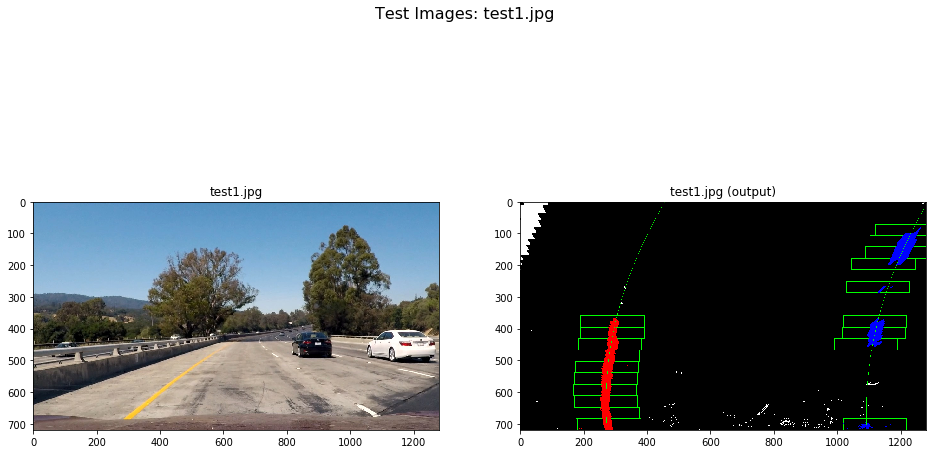

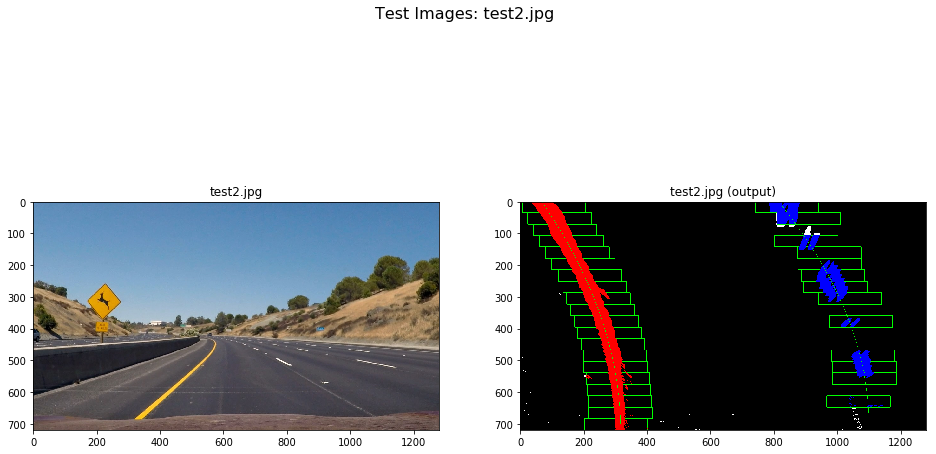

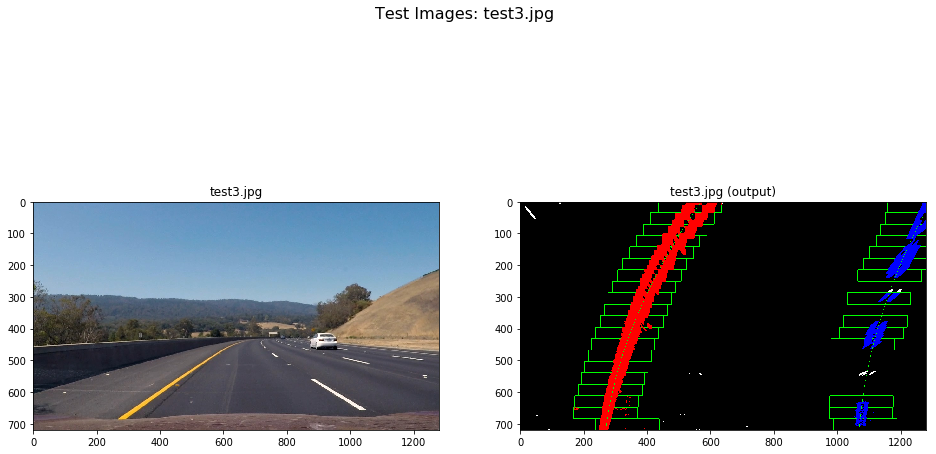

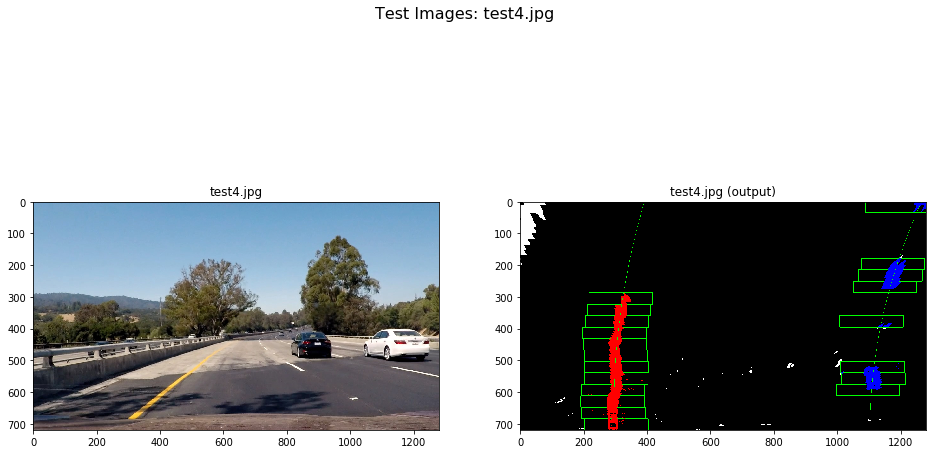

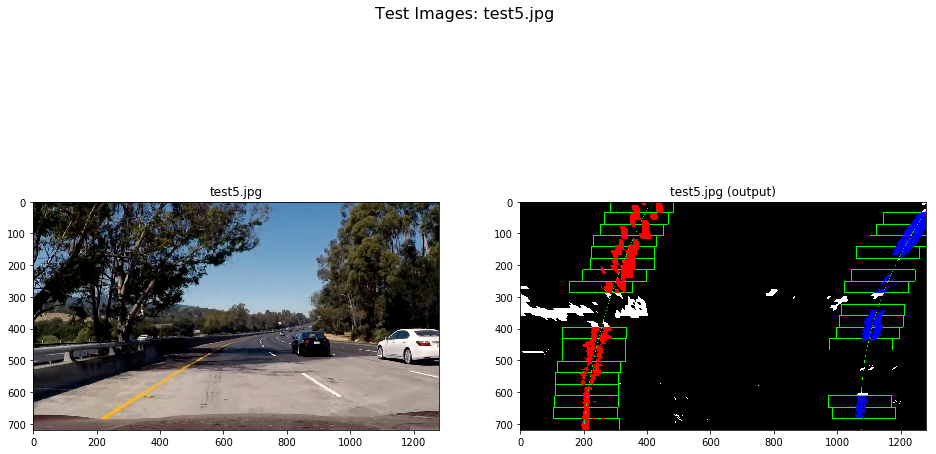

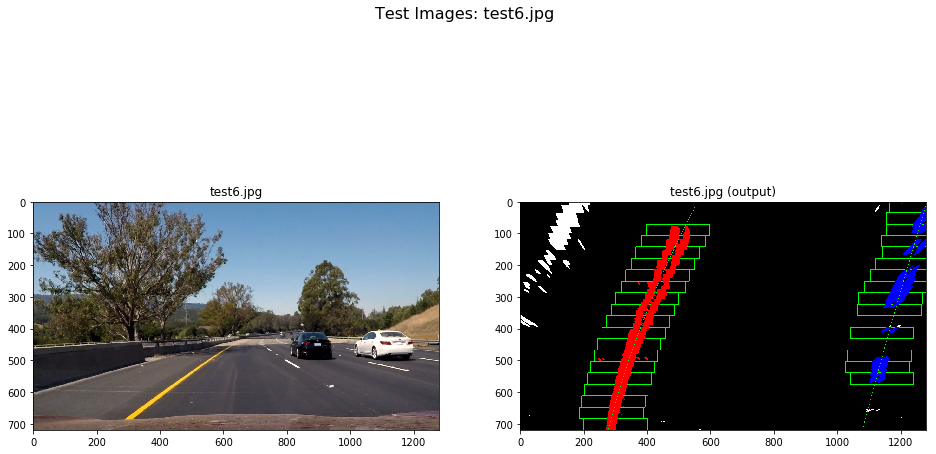

In [14]:
for k in range(1,7):
    # load test image
    fname = 'test' + str(k) + '.jpg'
    raw_img = mpimg.imread('test_images/' + fname)
    
    left_fit, right_fit, out_img_fit = laneLinesPipe(raw_img)

    fig, ax = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle('Test Images: ' + fname, fontsize=16)
    
    ax[0].imshow(raw_img)
    ax[0].set_title(fname)
    
    ax[1].imshow(out_img_fit)
    ax[1].set_title(fname + " (output)")

# Determine the Lane Curvature

Even though, the lane lines live on the 2-D road surface, they can be described a a general function of the form

\begin{equation*}
    y = f(x) 
\end{equation*}

In other words, one variables, *y* can always be treated as dependant on *x*.  This means that curvature can be caluclated using a simplified equation.  

\begin{equation*}
    k = \frac{y''} { \left( 1 + ( y' ) ^2 \right) ^{ \frac{2}{3} } }
\end{equation*}

where

\begin{equation*}
    y' = \frac{dy}{dx}
\end{equation*}

\begin{equation*}
    y'' = \frac{d^2y}{dx^2}
\end{equation*}

Curvature is the reciprical of radius of curvature.

\begin{equation*}
    |k| = \kappa = \frac{1} { R }
\end{equation*}

where *R* is the radius of curvature.

For a quadratic equation of the form 

\begin{equation*}
    y = c_2x^2 + c_1x + c_0
\end{equation*}

like the one we are using to estimate lane lines.

\begin{equation*}
    y' = 2c_2x + c_1
\end{equation*}

\begin{equation*}
    y'' = 2c_2
\end{equation*}

Note using our image notation, that *x* and *y* are swapped compare to the trandition *x* and *y* convention used to describe curvature.


In [15]:
# dimensions used for perspective transforms  
#   dx_m = 3.7 # approximate lane width (m)
#   dy_m = 30. # approimate distance to source points (m)
#   dx_px = 640.
#   dy_px = 719.  

def calcCurvature(coefficients, x = 719., x_scale = dy_m / dy_px, y_scale = dx_m / dx_px):
    # in will be assume the the coefficients are length 3 and represent a quadratic polynomial, 
    # but this could be easily extended to a polynomial of any order.

    scale  = x_scale / y_scale
    
    yp = (2 * coefficients[0] * x + coefficients[1]) * scale
    ypp = (2 * coefficients[0]) * scale * scale
    
    k = ypp / ( (1 + yp ** 2) ** 1.5)
    
    return k
    

# Lane Polynomials Projection onto Image

The purpose of this function to to overlay the original image with a polynomial fill created used the polynomials approximation of the left and right lanes.

In [16]:
def laneProjection(image, left_fit, right_fit):
    # xMax = image.shape[1] - 1
    # yMax = image.shape[0] - 1
    
    if (left_fit is not None) and (right_fit is not None):
    
        # Spread y points evening across of image at desired resolution
        pixel_res = 10
        ploty = np.int32(np.linspace(0, image.shape[0]-1, int(image.shape[0] / pixel_res)))

        # using polynomial coefficients to create left and right x values
        left_fitx = np.int32(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
        right_fitx = np.int32(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])

        # Create a single set of points defining polygon
        left = np.array([left_fitx, ploty]).T
        right = np.array([right_fitx[::-1], ploty[::-1]]).T   
        pnts = np.concatenate((left, right), axis = 0)

        # draw polygon fill
        polyfill = drawPolygonFill(flat_img, pnts)

        # change perspective from bird-eye to original
        inv_img = changePerspective(polyfill, Minv)
        
        
        k_left = calcCurvature(left_fit)
        k_right = calcCurvature(right_fit)
        
        k = (k_left + k_right) / 2.

        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (600,50)
        fontScale = 1
        fontColor = (255,255,255)
        lineType = 2

        k_str = "k = {:.6f}".format(k)
        cv2.putText(inv_img,k_str, 
            location, 
            font, 
            fontScale,
            fontColor,
            lineType)
        
        if (0.000001 < abs(k)):
            k_str = "radius = {:.0f}m".format(1./k)  
            location = (600,100)
            
            cv2.putText(inv_img,k_str, 
            location, 
            font, 
            fontScale,
            fontColor,
            lineType)

        # added lane poly to image
        result = weighted_img(inv_img, image)    
    else:
        result = np.copy(image)
        
    return result

## Verify and Visualize

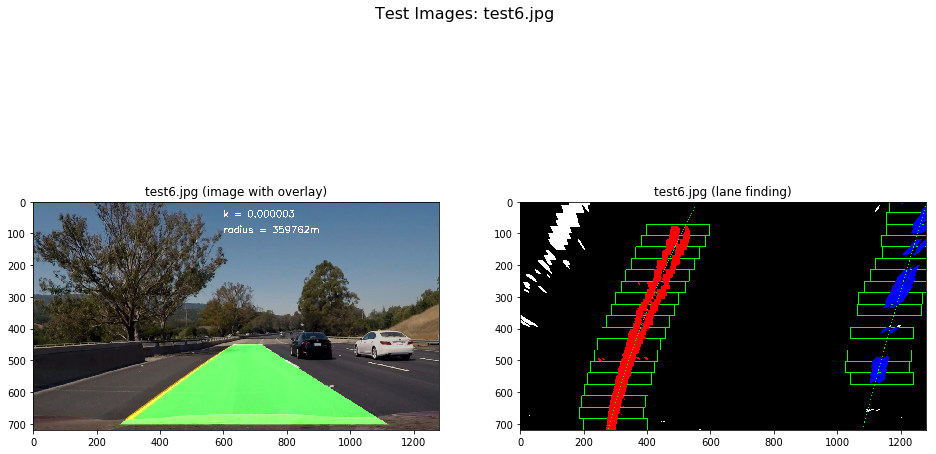

In [17]:
for k in range(6,7):
    # load test image
    fname = 'test' + str(k) + '.jpg'
    image = mpimg.imread('test_images/' + fname)
    
    left_fit, right_fit, out_img_fit = laneLinesPipe(image)
    
    overlay_img = laneProjection(image, left_fit, right_fit)

    fig, ax = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle('Test Images: ' + fname, fontsize=16)
    
    ax[0].imshow(overlay_img)
    ax[0].set_title(fname + ' (image with overlay)')
    
    ax[1].imshow(out_img_fit)
    ax[1].set_title(fname + " (lane finding)")

# Lane Smoothing Kalman Filter

## Kalman Filter Class

In [18]:
class KalmanLanes:
    def __init__(self):
        self.reset()

    def reset(self):
        self.X = None

        # State update martix
        self.F = np.identity(4, dtype = np.float64)

        # Initial Covariance matrix
        self.P = np.diag(np.array([1e8, 1e8, 1e6, 1e6]))
        self.P.astype(np.float64)
        
        # State Noise Covariance martix
        self.Q = np.diag(np.array([1e1, 1e1, 1e1, 1e0]))
        self.Q.astype(np.float64)
    
    def update(self, left_pnts, right_pnts, binary_warped):
        if (self.X is None):
            # initialize state using histogram from imge
            leftx_base, rightx_base = reset_lane_base(binary_warped)
            self.X = np.matrix([0., 0., leftx_base, rightx_base - leftx_base], dtype = np.float64).reshape(4,1)
        else:
            # prediction update
            self.predition_update()
        
        # measurement update
        self.measurement_update(left_pnts, right_pnts)

        # polynomial coefficients
        # dividing by 720 to account for normalizing y inputs
        left_fit = np.array([self.X[0] / (720. ** 2), self.X[1] / 720., self.X[2]])
        right_fit = np.array([self.X[0] / (720. ** 2), self.X[1] / 720., self.X[2] + self.X[3]])
        left_fit = left_fit.reshape(3)
        right_fit = right_fit.reshape(3)
        
        return left_fit, right_fit

    def measurement_update(self, left_pnts, right_pnts):
        # H measurement matrix
        H_left = self.H_left(left_pnts[:,0])
        H_right = self.H_right(right_pnts[:,0])
        H = np.concatenate((H_left, H_right), axis = 0)
    
        # measurement covariance amtrix
        R = np.diag(np.concatenate((left_pnts[:,2], right_pnts[:,2]), axis = 0))
        R.astype(np.float64)
        
        z = np.concatenate((left_pnts[:,1], right_pnts[:,1]), axis = 0)
        z = z.reshape((z.shape[0],1))
        z.astype(np.float64)
        z_hat = np.matmul(H, self.X)

        # measurement error or residual
        e = np.subtract(z, z_hat)

        # measurement prediction covariance
        S =  np.add(np.matmul(H, np.matmul(self.P, H.T)), R)

        # Kalman gain
        K = np.matmul(self.P, np.matmul(H.T, np.linalg.inv(S)))

        # update state covariance from measurement
        self.P = np.subtract(self.P, np.matmul(K, np.matmul(S, K.T)))
        
        # update state
        self.X = np.add(self.X, np.matmul(K, e))

    def predition_update(self):
        self.X = np.matmul(self.F, self.X)
        self.P = np.add(np.matmul(self.F, np.matmul(self.P, self.F.T)), self.Q)

    def H_right(self, y):
        # H = [y^2 y 1 1]
        H = np.ones((y.shape[0], 4), dtype = np.float64)
        
        # dividing by 720 to normalize y input for numerical stability
        H[:,0] = np.multiply(y / 720., y / 720.)
        H[:,1] = y / 720.

        return H

    def H_left(self, y):
        # H = [y^2 y 1 0]
        H = self.H_right(y)
        H[:,3] = np.zeros(y.shape)

        return H 
    

## Kalman Pipeline

In [19]:
kLanes = KalmanLanes()

def laneLinesPipeKalman(img):
    # undistort image
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # apply color and gradient thresholds
    color_grad_img = ColarGradientThreshold(dst_img, s_thresh = (170, 255), sx_thresh = (20, 200)) 
    
    # warp image with perspective transfrom
    binary_warped = changePerspective(color_grad_img, Mpersp)
    
    # Find lane points that summarize all the pixel found for the left and right lanes
    leftx, lefty, rightx, righty, left_pnts, right_pnts, out_img = find_lane_pixels(binary_warped)
    
    # Kalman filter estimate of lane polynomials
    left_fit, right_fit = kLanes.update(left_pnts, right_pnts, binary_warped)

    return left_fit, right_fit, out_img

## Verify and Visualize Kalman Pipeline

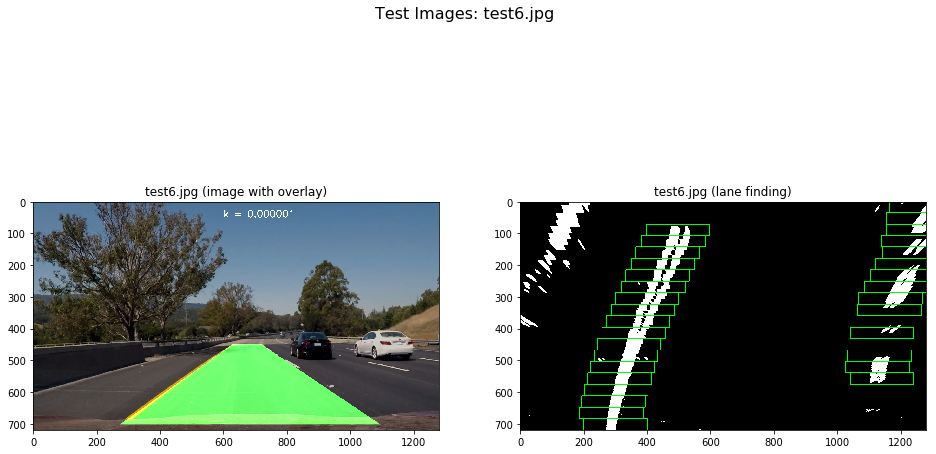

In [20]:
kLanes.reset()

for k in range(6,7):
    # load test image
    fname = 'test' + str(k) + '.jpg'
    image = mpimg.imread('test_images/' + fname)
    
    for k in range(1):
        left_fit, right_fit, out_img_fit = laneLinesPipeKalman(image)
    
    overlay_img = laneProjection(image, left_fit, right_fit)

    fig, ax = plt.subplots(1, 2, figsize=(16, 9))
    fig.suptitle('Test Images: ' + fname, fontsize=16)
    
    ax[0].imshow(overlay_img)
    ax[0].set_title(fname + ' (image with overlay)')
    
    ax[1].imshow(out_img_fit)
    ax[1].set_title(fname + " (lane finding)")

# Test on Video

Code borrowed from project #1.

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
# reset or re initialize Kalman filter class
kLanes.reset()

def process_image(image):
    
    # fit polynomial to lines
    #left_fit, right_fit, out_img_fit = laneLinesPipe(image)
    
    # Kalman pipeline
    left_fit, right_fit, out_img_fit = laneLinesPipeKalman(image)
    
    # project left and right polynomials onto original image
    result = laneProjection(image, left_fit, right_fit)

    return result

In [23]:
project_output = 'output_images/project_output.mp4'
clip = VideoFileClip("project_video.mp4")
adv_lane_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time adv_lane_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


100%|█████████▉| 1260/1261 [04:06<00:00,  5.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 7min 10s, sys: 5min 50s, total: 13min 1s
Wall time: 4min 7s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))